# Configuración de Dataset y Modelo
Estos parametros nos permiten aplicar distintos tipos de implementaciones al modelo para probar la mejor configuración

In [1]:
# Permite calcular la superficie por cantidad de ambientes, para darle un peso correcto a los ambientes.
# Este valor no se utiliza si UTILIZAR_ROOMS es False
CALCULAR_SUPERFICIE_POR_AMBIENTE = True

# Permite indicar si utilizamos el campo rooms para nuestro modelo o no.
# Con True mejora el score r2 en un unas milesimas nomás
UTILIZAR_ROOMS = True

# Permite indicar que no usemos el campo FLOOR en nuestros datos
UTILIZAR_FLOOR = True

# Permite indicar que usemos o no el campo EXPENSES en nuestros datos
UTILIZAR_EXPENSES = True

# indica si se calcula la superficie por cada ubicación con las dummies.
PLACE_X_SURFACE = True

# Indica si la superficie debe ser calculada por property type en las cummies de Property Type
PROPERTY_TYPE_X_SURFACE = True

# La antiguedad es obtenida de la descripción y no logramos obtener demasiada información de la misma.
# Aproximadamente unos 3100 registros con el valor de antiguedad. 
# Este parametro nos permite comparar el modelo con y sin antiguedad.
UTILIZAR_ANTIGUEDAD = True

# Indica si debemos utilizar la ubicación para el modelo.
UTILIZAR_UBICACION = True

# Indica hasta que nivel de ubicacion realizar el entreenamiento
# 1: País
# 2: Pais y Provincia
# 3: Pais, Provincia y Ciudad => Mejor Score
# 4: Pais, Provincia, Ciudad y Barrio
NIVEL_UBICACION = 4

# Definimos las ubicaciones que vamos a usar para nuestro modelo
#UBICACIONES = ['bs.as.','córdoba','santa fe', 'capital federal']
UBICACIONES = []

# Definimos ubicaciones a excluir
EXCLUIR_UBICACIONES = []

# Indica si elimino los outliers de precios del dataset
ELIMINAR_OUTLIER_PRECIOS = True

# Indica que se deben eliminar las superficies que tienen un valor menor o igual a cero
ELIMINAR_SUPERFICIES_EN_CERO_Y_NULL = True

# Indica que se deben eliminar las superficies que son outliers
ELIMINAR_OUTLIER_SUPERFICIES = True

# Indica si se deben eliminar los registros duplicados
ELIMINAR_DUPLICADOS = True

# Indica si el modelo debe identificar 
IDENTIFICAR_BARRIOS_PRIVADOS = False

# Identifica el campo a utilizar como superficie
CAMPO_SUPERFICIE = 'surface_covered_in_m2'

# Pasos Iniciales

## Importación de Librerías
Importamos las librerías que vamos a utilizar en toda la notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

Definímos funciones y variables que nos van a permitir reutilizar el código a lo largo de la notebook

**Columnas a eliminar**<br>
Para eliminar las columnas en un solo paso una variable llamada **cols_to_drop** con los nombres de columnas que queremos eliminar, y en cada análisis, donde corresponda, vamos a agregar el nombre de la columna que deseamo eliminar. <br>
En el último paso, procedemos a ejecutar la función drop, utilizando la lista de columnas a eliminar.

In [3]:
# Guarda el listado de columnas a eliminar del dataframe
cols_to_drop = []

def add_column_to_drop(col_name, df):
    "Agrega el nombre de una columna a eliminar ('col_name') del dataframe ('df') en la lista de columnas a eliminar ('cols_to_drop'), verificando que no haya sido eliminada previamente, para luego utilizar la lista 'cols_to_drop' para eliminarlas del dataset"
    
    # Agregamos la condición que verifica si la columna existe por si se ejecuta dos veces el proceso.
    # Esto evita que nos arroje un error
    if ~(col_name in cols_to_drop) & (col_name in df.columns):
        # Agregamos la columna a la lista de columnas a eliminar
        cols_to_drop.append(col_name)
        print('La columna "',col_name,'" va a ser eliminada del DataFrame')
    else:
        print('La columna "',col_name,'" ya había sido eliminada del DataFrame')

***Inspeccionar NaNs***<br>
Creamos una función que nos permite ver de manera prolija, la información de un DataFrame

In [4]:
def inspect_dataframe(df):
    "Muestra los datos de un dataframe como en '.info()' pero de una manera mas facil de leer."
    
    # Cantidad total de registros
    total_rows = len(df)

    # Creamos el dataframe donde vamos a mostrar la estructura del dataset
    # Algo así como el .info() pero con mas información.
    df_retval = pd.DataFrame(columns=['NaNs #','NaNs %','Type'])

    # Por cada columna
    for col in df.columns:
        
        # Cantidad de Valores nulos
        nan_values = df[col].isnull().sum()
        
        # Porcentaje de Valores Nulos en el dataset
        nan_percentage = nan_values / total_rows * 100
        
        # El tipo de dato de la columna
        datatype = df[col].dtype
        
        # Agrego la fila al dataframe
        df_retval.loc[col] = [nan_values, nan_percentage, datatype]
    
    # Ordeno los valores por % de NaNs
    return df_retval.sort_values(by='NaNs %', ascending=False)

***Imputa NaNs con flag***<br>
Creamos una función que nos imputa a una columna, el valor indicado y crea una nueva columna que indica si el registro fue imputado.

In [5]:
def impute_nans_with_flag(col_name,df, value, create_flag = True):
    "Imputa los valores NaN con el valor de value y crea una columna que indica si al registro se le imputo un valor o no"
    
    if (create_flag):
        # Creamos el nombre de la columna FLAG
        flag_col = col_name + '_was_nan'
    
        # Creamos la columna con los valores true o false donde corresponda
        df[flag_col] = df[col_name].isnull().astype(int)
    
    # Asignamos 0 a los registros que son null
    df.loc[df[col_name].isnull(),col_name] = value

#### Distancia entre dos puntos de coordenadas
Creamos una función que nos devuelve la distancia en kilometros entre dos puntos de coordenadas.
Usamos esto para comparar nuestro dataset de propiedades contra el dataset de barrios privados.

In [6]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

### Lectura del dataset de Barrios Privados

In [7]:
# Cargamos el dataset de barrios privados.
BARRIOS_PRIVADOS = pd.read_csv('barrios_privados_argentina_corrected.csv', encoding='latin1')
BARRIOS_PRIVADOS['lat'] = BARRIOS_PRIVADOS['lat'].str.replace(',','.').astype(float)
BARRIOS_PRIVADOS['lon'] = BARRIOS_PRIVADOS['lon'].str.replace(',','.').astype(float)

## Lectura de Dataset de Propiedades
Cargamos el Dataset en un dataframe y analizamos la estructura inicial y datos nulos.

In [8]:
# Leemos el CSV
dataframe = pd.read_csv('properatti.csv',index_col=0)    

Observamos la correlación inicial entre variables que podrían tener algun tipo de relación con el precio

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text xticklabel objects>)

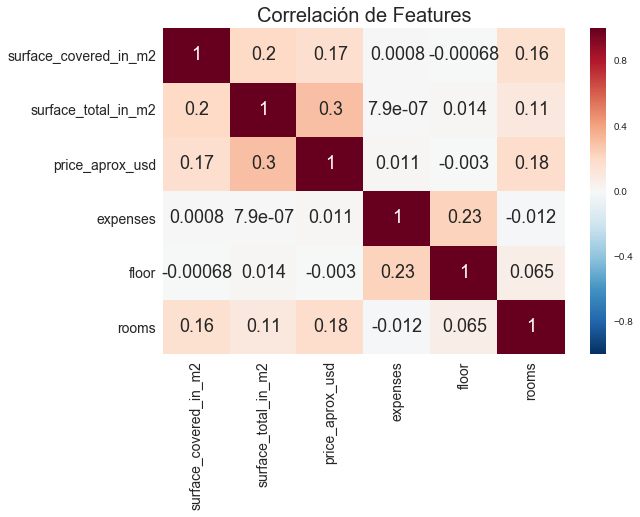

In [9]:
plt.figure(figsize=(9,6))
sns.heatmap(dataframe[['surface_covered_in_m2','surface_total_in_m2','price_aprox_usd','expenses','floor','rooms']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Correlación de Features', fontsize=20)
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=14)

## Analizamos la estructura del dataset

Observamos el % de valores NaN para cada campo

In [10]:
# Obtengo la Info
df_info = inspect_dataframe(dataframe)
# Muestro la info
df_info

,NaNs #,NaNs %,Type
floor,113321,93.483749,float64
expenses,106958,88.234615,float64
rooms,73830,60.905791,float64
price_usd_per_m2,52603,43.394654,float64
lat-lon,51550,42.525986,object
lat,51550,42.525986,float64
lon,51550,42.525986,float64
surface_total_in_m2,39328,32.443491,float64
price_per_m2,33562,27.686850,float64
currency,20411,16.837981,object


A partir de la información del dataset podemos observar que existen columnas con muy pocos datos nulos y otras con una gran cantidad. De estas columnas, tenemos que definir cuales son significativas y vamos a requerir procesar los datos nulos, y cuales no.

## Observación de registros iniciales
Observamos los primeros registros para entender un poco como están representados los datos.

In [11]:
dataframe.head(10)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
5,sell,house,Gualeguaychú,|Argentina|Entre Ríos|Gualeguaychú|,Argentina,Entre Ríos,3433657.0,"-33.0140714,-58.519828",-33.014071,-58.519828,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bop_venta_depart...,"Casa en el perímetro del barrio 338, ubicada e...","Casa Barrio 338. Sobre calle 3 de caballería, ...",https://thumbs4.properati.com/6/q-w68gvaUEQVXI...
6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,-58.521782,...,78.0,1226.415094,1666.666667,NaN,NaN,NaN,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",https://thumbs4.properati.com/5/6GOXsHCyDu1aGx...
7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,...,40.0,3066.666667,3450.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...
8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,-58.443362,...,60.0,3000.000000,3250.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...
9,sell,house,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.942031,-60.7259192",-32.942031,-60.725919,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15box_venta_casa_r...,MEDNOZA AL 7600A UNA CUADRA DE CALLE MENDOZAWH...,WHITE 7637 - 2 DORMITORIOS CON PATIO,https://th

## Filtrar ciudades
Filtramos para obtener solo las ciudades elegidas en la configuración

In [12]:
dataframe = dataframe.loc[
    (dataframe['place_with_parent_names'].str.lower().str.contains('|'.join(UBICACIONES))) |
    (len(EXCLUIR_UBICACIONES) == 0 | (~dataframe['place_with_parent_names'].str.lower().str.contains('|'.join(EXCLUIR_UBICACIONES))))
    ]

## Es barrio Privado?
Creamos una nueva categoría que nos permite identificar si una propiedad está ubicada en un barrio privado. Realizamos esto como primer paso, ya que vamos a crear un nuevo CSV con esta información extra, para que cuando corramos el proceso nuevamente, no haya que volver a realizar el calculo.<br>
Simplemente guardamos los datos procesados la primera vez, y las proximas veces se lee el nuevo CSV sin la necesidad de correr el proceso otra vez.

In [13]:
from IPython.display import clear_output
import gpxpy.geo


# Funcion que nos permite definir si una propiedad está ubicada dentro de un barrio privado
def obtener_barrio_privado(row_propiedad, barrios):
    
    
    # Aca voy a guardar la dictancia minima encontrada para esta propiedad
    distancia_minima = np.nan
    
    # Aca guardo el barrio con la distancia mínima para esta propiedad
    barrio_cercano = np.nan

    # Recorremos cada barrio y obtenemos la distancia entre la propiedad y el barrio.
    # Por cada barrio
    for i, barrio in barrios.iterrows():
        
        # Obtengo la distancia entre el barrio y la propiedad
        #distancia = haversine(barrio['lat'], barrio['lon'], row_propiedad['lat'], row_propiedad['lon'])
        distancia = gpxpy.geo.haversine_distance(barrio['lat'], barrio['lon'], row_propiedad['lat'], row_propiedad['lon'])
        
        # Si la distancia no es un nan
        if ~np.isnan(distancia):
            
            # Si la distancia anterior es nan o la distancia encontrada es menor que la distancia mínima encontrada anteriormente
            if (np.isnan(distancia_minima)) | (distancia < distancia_minima):
                # Asigno el barrio a la variable barrio_cercano
                barrio_cercano = barrio
                
                # Asigno la nueva distancia
                distancia_minima = distancia
                    
        
    if (~np.isnan(distancia_minima)):
        # Le asigno el valor de distancoia y barrio a la propiedad, teniendo en cuenta que si no encontró ninguna,
        # estos valores van a ser nan
        row_propiedad['distancia_barrio_privado'] = distancia_minima
        row_propiedad['nombre_barrio_privado'] = barrio_cercano['barrio']
            
    
    return row_propiedad

### Ejecutamos la función.
Creamos un CSV con los datos procesados hasta acá. Esto nos sirve para que no procese todo el tiempo los barrios privados, ya que es un proceso MUY largo.

In [14]:
import os.path

if IDENTIFICAR_BARRIOS_PRIVADOS:
    
    # Nombre del dataset con los barrios privados ya procesados
    dataset_con_barrios = 'properatti_barrios_privados_sup_total.csv'
    
    # Si el archivo existe
    if os.path.isfile(dataset_con_barrios):
        # Cargo del archivo en el dataframe original
        dataframe = pd.read_csv(dataset_con_barrios, encoding='latin1')
    else:
        # Si el archivo no existía
        # Creo las columnas de barrio privado y distancia
        dataframe['distancia_barrio_privado'] = np.nan
        dataframe['nombre_barrio_privado'] = np.nan
    
    
    # Obtengo las ciudades de los barrios
    ciudades_barrios_privados = BARRIOS_PRIVADOS['ciudad'].str.lower().unique()
        
    # Obtengo solo las propiedades que estan en las ciudades de los barrios privados Y QUE NO TENGAN LA DISTANCIA
    df_busqueda = dataframe.loc[(dataframe['distancia_barrio_privado'].isnull()) & # Que aun no tengan la distancia
                                (~dataframe['place_name'].isnull()) &  # Que tengan nombre de ciudad
                                (dataframe['place_name'].str.lower().str.contains('|'.join(ciudades_barrios_privados)))
                                ].copy()
        
    print(len(df_busqueda),'estan en ciudades de barrios privados')
        
    totalciudades = len(ciudades_barrios_privados)
    current = 1
    
    # Sabemosque si hay 1577 propiedades, ya estan procesadas por lo que no corremos el proceso si tenemos esa cantidad
    if len(df_busqueda) > 1577:
        # por cada ciudad de los barrios
        for ciudad in ciudades_barrios_privados:
    
            # Obtengo los barrios de cada ciudad
            df_barrios = BARRIOS_PRIVADOS.loc[BARRIOS_PRIVADOS['ciudad'].str.lower() == ciudad.lower()].copy()
            
            # Obtengo las propiedades que son de esa ciudad
            df_props_ciudad = df_busqueda.loc[(df_busqueda['distancia_barrio_privado'].isnull()) &
                                              (~df_busqueda['place_name'].isnull()) & 
                                              (df_busqueda['place_name'].str.lower().str.contains(ciudad.lower()))].copy()
            
            # Solo proceso si hay propiedades para esa ciudad.
            if (len(df_props_ciudad) > 0):
                
                print('Procesando ciudad',ciudad,'-',current,'de',totalciudades,'-',len(df_props_ciudad),'propiedades')
                
                # Recorremos cada propiedad y tratamos de obtener el barrio privado mas cercano a esa propiedad, basados en la ubicación.    
                df_props_ciudad = df_props_ciudad.apply(obtener_barrio_privado, axis=1, barrios=df_barrios)
        
                # Actualizo los valores 
                df_busqueda.update(df_props_ciudad)
            
                current = current + 1
            
                # Actulizo los valores del dataframe original con los del dataframe con los barrios
                dataframe.update(df_busqueda)

                # guardo dataframe actualizado    
                dataframe.to_csv(dataset_con_barrios, index=False)    


### Propiedades que no estan cerca de barrios.
Creamos una nueva feature que indica que la propiedad no está cerca de ningún barrio privado. Esto lo hacemos por que las propiedades que no estan cerca, tienen distancia CERO y esperamos que el modelo compute con mas peso a los valores mas cercanos a los barrios privados. Si agregamos una columna con valor 1 para las propiedades que tienen distancia 0 a los barrios privados, se genera un beta ($\beta$) nuevo para esas.


In [15]:
if IDENTIFICAR_BARRIOS_PRIVADOS:
    # Creamos la columna que indica que no está cerca de un barrio privado (bp)
    dataframe['sin_cercania_a_bp'] = 0
    
    # Asignamos el valor 0 a la columna 'distancia_barrio_privado',  1 a la columna sin_cercania_a_bp
    # y 'None' a la columna nombre_barrio_privado
    dataframe.loc[
        (dataframe['distancia_barrio_privado'].isnull()) |  # Si la columna distancia_barrio_privado es null
        (dataframe['distancia_barrio_privado'].isnull() > 7), # O si la columna distancia barrio privado es mayor a 7
        ['distancia_barrio_privado','sin_cercania_a_bp', 'nombre_barrio_privado']] = [0,1,'None']
    
    # Le asignamos el valor None a la columna nombre_barrio_privado donde es mayor que 7 NULL
    dataframe.loc[(dataframe['sin_cercania_a_bp'] == 1),'nombre_barrio_privado'] = 'None'

# Data Cleaning
Comenzamos el proceso de limpieza de datos. 

## Floor
El campo floor representa el piso en donde está ubicada la propiedad, si corresponde. Asumimos que tienen NaN, las propiedades que no son apartment, pero hacemos la verificación para comprobarlo.

In [16]:
# Obtengo el valor de NaNs en el campo floor
total_nan_floor = df_info.loc['floor']['NaNs #']

# Obtengo el total de valores NaN en el campo floor, cuando property_type es apartment.
total_nan_floor_apartment = len(dataframe.loc[(dataframe['property_type'] == 'apartment') & (dataframe['floor'].isnull())])

# Muestro los datos
print('De un total de',total_nan_floor,'registros nulos en floor,')
print('existen',total_nan_floor_apartment,'registros del tipo *apartment*, con valor NaN en floor.')
print(str(total_nan_floor_apartment / total_nan_floor),'%.')

De un total de 113321 registros nulos en floor,
existen 64544 registros del tipo *apartment*, con valor NaN en floor.
0.5695678647382215 %.


A todas las propiedades les imputamos el valor 0 y creamos una variable que indica si a ese registro se le imputó un valor.<br>
La columna se va a llamar **floor_was_nan**

In [17]:
# Imputamos 0 y creamos un flag que indica la imputación
impute_nans_with_flag('floor', dataframe, 0, True)

dataframe.loc[dataframe['floor_was_nan'] == True, 'floor_was_nan'].count()

113321

### Pisos 0
Para mantener una coherencia, vamos a establecer que cuando el FLOOR es 0, va a ser 1.

In [18]:
dataframe.loc[dataframe['floor'] == 0,'floor'] = 1

## Expenses

Al igual que la columna floor, esta columna tiene una gran cantidad de datos missing (88%). Aplicamos la misma técnica que en **floor** poniendo en 0 los valores nan y creando una variable que nos indica que esa columna fue imputada.<br>
La columna se llamará **expenses_was_nan**

In [19]:
# Imputamos 1 y creamos un flag que indica la imputación
impute_nans_with_flag('expenses', dataframe, 0, False)

# Dividimos por 100 sin resto. Esto nos permite aplicarle un peso a las expensas mayores o iguales a 1000
dataframe['expenses'] = (dataframe['expenses'] > 0).astype(int)
#dataframe.loc[dataframe['expenses_was_nan'] == True, 'expenses_was_nan'].count()

## Ubicación
Vamos a usar la ubicación solo hasta el nivel indicado en la configuración<br>
* 1: Pais
* 2: Pais y Provincia
* 3: Pais, Provincia y Ciudad
* 4: Pais, Provincia, Ciudad y Barrio

In [20]:
# Obtenemos las ubicaciones hasta el 3er nivel.
dataframe['place'] = dataframe['place_with_parent_names'].apply(lambda place: '|'.join(place.split('|')[1:NIVEL_UBICACION + 1]))

# Eliminamos la columna place_with_parent_names
dataframe = dataframe.drop('place_with_parent_names', axis=1)

## Columnas concatenadas
Existen dos columnas en el dataset, cuyos datos son la union de varios. A su vez, estos datos están procesados y separados en varias columnas.

### Latitud y Longitud
Está representado en la columna ***lat-lon*** con los dos valores en la misma columna tipo string y por las columnas ***lat*** y ***log*** (float). <br>
Decidimos eliminar la columna ***lat-lon*** ya que nos es mas util tenerlas separadas que concatenadas.

### Nombre de ubicaciones
Existen 4 columnas columnas de nombres de ubicaciones, que representan el país, la zona y el barrio. ***place_with_parent_names*** contiene los tres valores separados por un pipe ("**|**") y luego, estos tres valores se repiten en las columnas ***country_name***, ***state_name*** y ***place_name***.  <br>
Decidimos eliminar las columnas ***country_name***, ***state_name*** y ***place_name*** ya que son variables categóricas y la columna ***place_with_parent_names*** nos permite representar todas las posibilidades de categorías.

In [21]:
# Preparamos las columnas a eliminar
add_column_to_drop('lat-lon', dataframe)
add_column_to_drop('country_name', dataframe)
add_column_to_drop('state_name', dataframe)
add_column_to_drop('place_name', dataframe)

La columna " lat-lon " va a ser eliminada del DataFrame
La columna " country_name " va a ser eliminada del DataFrame
La columna " state_name " va a ser eliminada del DataFrame
La columna " place_name " va a ser eliminada del DataFrame


## Superficie
Analizamos las variables de superficie (**surface_total_in_m2** y **surface_covered_in_m2**) y su relación con el precio (**price**) para identificar si el precio está basado en la superficie cubierta o en la superficie total.

### Qué Representa el precio?

Identificamos que el precio de las propiedades es por m2 totales (**surface_total_in_m2**), calculando el precio / precio por metro cuadrado. Esto nos devuelve un valor que cuando lo comparamos contra superficie total vemos que es exactamente el mismo, por lo que encontramos que hay una relación directa de precio total contra superficie total

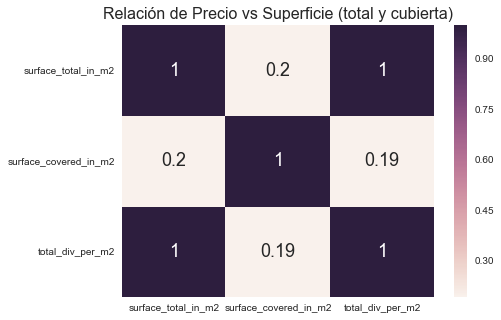

In [22]:
df_tmp = dataframe[['price_aprox_usd','price_usd_per_m2','surface_total_in_m2','surface_covered_in_m2']].copy()
df_tmp['total_div_per_m2'] = df_tmp['price_aprox_usd'] / df_tmp['price_usd_per_m2']

plt.figure(figsize=(7,5))
sns.heatmap(df_tmp[['surface_total_in_m2','surface_covered_in_m2','total_div_per_m2']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Relación de Precio vs Superficie (total y cubierta)', fontsize=16)

### Basado en precios en dolares
Calculamos la superficie total basada en el precio total en dolares / el precio por m2

In [23]:
# SOLO CALCULAMOS SI NO SE PIDE ELIMINAR A LAS NAN Y 0. SINO LAS ELIMINAMOS COMPLETAMENTE.

if ELIMINAR_SUPERFICIES_EN_CERO_Y_NULL == False:
    # Creamos un flag que indica si la superficie fue calculada
    dataframe['surface_was_nan'] = 0

    # Columnas de Dolares que no sean null pero que la superficie sea null
    df_tmp = dataframe.loc[
        (~dataframe['price_aprox_usd'].isnull()) & 
        (~dataframe['price_usd_per_m2'].isnull()) &
        ((dataframe[CAMPO_SUPERFICIE].isnull()) | (dataframe[CAMPO_SUPERFICIE] == 0)) # Que sea nulo o Cero
    ].copy()

    # Calculamos la superficie
    df_tmp['calculated_surface'] = df_tmp['price_aprox_usd'] / df_tmp['price_usd_per_m2']
    
    
    # Asigno la cuperficie calculada al dataframe original
    dataframe.loc[
        (~dataframe['price_aprox_usd'].isnull()) & 
        (~dataframe['price_usd_per_m2'].isnull()) &
        (dataframe[CAMPO_SUPERFICIE].isnull()), [CAMPO_SUPERFICIE, 'surface_was_nan']] = [df_tmp['calculated_surface'], 1]

else:
    dataframe = dataframe.loc[(~dataframe[CAMPO_SUPERFICIE].isnull()) | (dataframe[CAMPO_SUPERFICIE] > 0)]

### Obtención de Superficie desde Descripción

Intentamos obtener superficies de la descripción

In [24]:
# Solo obtengo de la descripcion si no las voy a borrar
if ELIMINAR_SUPERFICIES_EN_CERO_Y_NULL == False:

    #Creo la mask para obtener los registros con superficie cubierta NaN o en 0
    mask = (dataframe[CAMPO_SUPERFICIE].isnull()) | (dataframe[CAMPO_SUPERFICIE] == 0)

    # Obtengo las superficies de la descripción
    tmp = dataframe.loc[mask,'description'].str.lower().str.extract('(((\d+)|(\d+(,|\.)\d+))(\s+|())mts|((\d+)|(\d+(,|\.)\d+))(\s+|())m2)', expand=False)

    #Establezco los valores al dataframe
    dataframe.loc[mask,[CAMPO_SUPERFICIE]] = [1,tmp[0].str.lower().str.replace('m2','').str.replace('mts','').count()]

### Missing Values de Superficie cubierta
Desfaortunadamente, nos quedan aun unos registros de los cuales no podemos obtener la Superficie total. Decidímos eliminar estos registros de nuestro dataset.

In [25]:
# Obtenemos el dataset con los datos que no tengan surface_covered_in_m2 en nulo
dataframe = dataframe.loc[~dataframe[CAMPO_SUPERFICIE].isnull()]

## Rooms
Intentamos obtener la cantidad de ambientes, para los missing values, de la descripción, utilizando expresiones regulares.<br>

Idem Expenses y Floor, pero le imputamos el valor 1 ya que no existen propiedades de 0 ambientes.

In [26]:
# Obtengo los ambientes mediante la descripcion
tmp = dataframe.loc[(dataframe['rooms'].isnull()),'description'].str.lower().str.extract("(\d+)(\s|())amb", expand=False)

# Asigno la cantidad de ambientes, al dataset original donde rooms es NaN
dataframe.loc[dataframe['rooms'].isnull(),'rooms'] = tmp[0]

# Asignamos 1 a las propiedades que en su descripción tengan la palabra 'monoambiente'
dataframe.loc[(dataframe['rooms'].isnull()) & (dataframe['description'].str.lower().str.contains('monoambiente')),'rooms'] = 1

### Imputamos los demas valores que no pudimos obtener de la descripción
Aplicamos la misma técnica que en floor y expenses, imputando 1 a los valores Missing, y creando una variable flag que indica al modelo cuales fueron imputados a mano. (**rooms_was_nan**)

In [27]:
# Imputamos 1 y creamos un flag que indica la imputación
impute_nans_with_flag('rooms', dataframe, 1)

# Contamos la cantidad de rooms que fueron imputados
print('Se imputaron',dataframe.loc[dataframe['rooms_was_nan'] == True, 'rooms_was_nan'].count(),'registros que tenian NaN en rooms')

# Convertimos Rooms a int
dataframe['rooms'] = dataframe['rooms'].astype(int)

Se imputaron 40260 registros que tenian NaN en rooms


### Rooms con valor 0
Tambien encontramos ambientes con el valor 0. Le imputamos 1 y le asignamos el flag como si hubiera sido NaN

In [28]:
# Lo marcamos como si hubiera sido NaN y le asignamos el valor 1
dataframe.loc[dataframe['rooms'] == 0, ['rooms_was_nan','rooms']] = [1, 1]


### Imputar Media de Habitaciones
Imputamos a las habitaciones que eran nan, la media de acuerdo a la ubicacion y tipo de propiedad

In [29]:
if UTILIZAR_ROOMS:
    # Obtenemos las ubicaciones
    places = dataframe['place'].unique()

    # por cada lugar
    for lugar in places:
    
        # Obtenemos las propiedades del lugar
        df_places = dataframe.loc[dataframe['place'] == lugar]
        
        # Obtenemos los tipos de propiedad de este lugar
        tipos = df_places['property_type'].unique()
        
        # por cada tipo en los tipos de propiedad
        for tipo in tipos:
            
            # Obtengo la media
            media = df_places.loc[(df_places['property_type'] == tipo) & (df_places['rooms_was_nan'] == 0), 'rooms'].mean()
    
            if (~np.isnan(media)):
                # Se la aplico a las propiedades que rooms era NaN
                dataframe.loc[
                    (dataframe['place'] == lugar)
                    & (dataframe['property_type'] == tipo)
                    & (dataframe['rooms_was_nan'] == 1)
                , 'rooms'] = media

### M2 per room
Creamos una feature que identifica los m2 por ambiente, para luego deshacernos de la cantidad de ambientes. Esto nos va a dar un valor con un peso mas relativo a la superficie de cada propiedad. <br>
Por último, asignamos -1 al flag que indicaba que era missing, ya que al tener 1 ambiente, le da mas peso, cuando en realidad debería darle menos. Con el flag en -1 logramos bajarle el peso a los que tienen un ambiente y era null

In [30]:
# Si queremos generar columna (Ver parametros arriba de todo)
if UTILIZAR_ROOMS & CALCULAR_SUPERFICIE_POR_AMBIENTE:
    # Calculamos m2 cubiertos / cantidad de ambientes
    dataframe['m2_per_room'] = dataframe.apply(lambda row: row[CAMPO_SUPERFICIE] / row['rooms'], axis=1)

    # Eliminamos la columna ROOMS ya que vamos a usar nuestra nueva columna
    dataframe = dataframe.drop('rooms', axis=1)

    # A los registros que tenian 1 en rooms_was_nan le asignamos -1 para bajarle el peso 
    dataframe.loc[dataframe['rooms_was_nan'] == 1, 'rooms_was_nan'] = -1
    
    # Y 1 a los que no eran nan para mentenerle el pero
    dataframe.loc[dataframe['rooms_was_nan'] == 0, 'rooms_was_nan'] = 0

### Correlación
Si utilizamos el parametro de ambientes y calculamos superficie por ambiente, podemos observar que existe una correlación mas fuerte con esta nueva variable, que con la cantidad de ambientes.

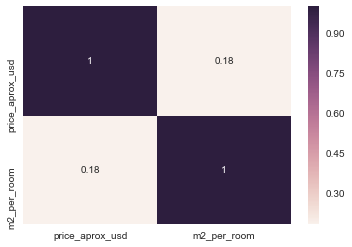

In [31]:
if UTILIZAR_ROOMS & CALCULAR_SUPERFICIE_POR_AMBIENTE:
    sns.heatmap(dataframe[['price_aprox_usd','m2_per_room']].corr(), annot=True)

## Divisas de los precios y columnas de precios
Decidimos utilizar los precios en **DOLARES** por lo que eliminamos las columnas de precios en otras monedas. <br>
La columna Currency tambien va a ser eliminada ya que usamos todos los precios en DOLARES

In [32]:
# Eliminamos las columnas que no usamos para precios
add_column_to_drop('price_usd_per_m2', dataframe)
add_column_to_drop('price_aprox_local_currency', dataframe)
add_column_to_drop('price', dataframe)
add_column_to_drop('currency', dataframe)
add_column_to_drop('price_per_m2', dataframe)


La columna " price_usd_per_m2 " va a ser eliminada del DataFrame
La columna " price_aprox_local_currency " va a ser eliminada del DataFrame
La columna " price " va a ser eliminada del DataFrame
La columna " currency " va a ser eliminada del DataFrame
La columna " price_per_m2 " va a ser eliminada del DataFrame


## Eliminamos las columnas deseadas
Una vez que tenemos la lista de columnas a eliminar, las eliminamos del dataframe

In [33]:
dataframe = dataframe.drop(cols_to_drop, axis=1)
print('Las columnas',cols_to_drop,'fueron eliminadas del DataFrame')
cols_to_drop = []

Las columnas ['lat-lon', 'country_name', 'state_name', 'place_name', 'price_usd_per_m2', 'price_aprox_local_currency', 'price', 'currency', 'price_per_m2'] fueron eliminadas del DataFrame


## Outliers

### Observamos los outliers de Precio y Superficie

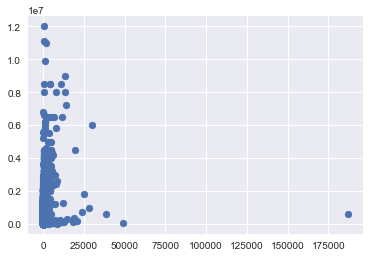

In [34]:
# Graficamos un Scatter de precio contra superficie
plt.scatter(x=dataframe[CAMPO_SUPERFICIE], y=dataframe['price_aprox_usd'])

Observamos las características de estos dos valores

In [35]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataframe[[CAMPO_SUPERFICIE,'price_aprox_usd']].describe()

,surface_covered_in_m2,price_aprox_usd
count,101313.000,87660.000
mean,133.050,246807.202
std,724.351,330608.182
min,0.000,4666.620
25%,45.000,93000.000
50%,75.000,150000.000
75%,150.000,280000.000
max,187000.000,12000000.000


### Superficie
Encontramos outliers en la superficie por m2. Para poder tratar correctamente estos, vamos a segmentarlos por ubicacion y tipo de propiedad y luego le aplicamos la media.

** Observamos la correlación entre precio y superficie cubierta antes de corregir los outliers **

(array([ 0.5,  1.5,  2.5]), <a list of 3 Text xticklabel objects>)

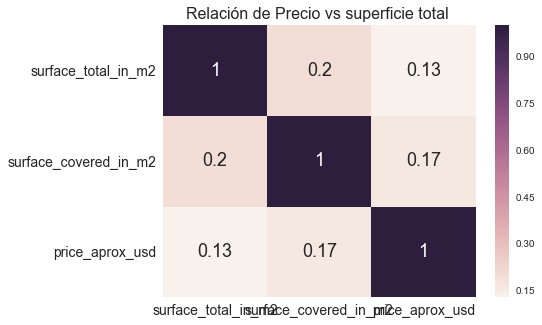

In [36]:
# Obtengo la correlación antes de eliminar outliers
df_corr_prev_outliers = dataframe[['surface_total_in_m2','surface_covered_in_m2','price_aprox_usd']].corr()

# Establezco el tamaño del plot
plt.figure(figsize=(7,5))
# Creo el heatmap
sns.heatmap(df_corr_prev_outliers, annot=True,annot_kws={"size": 18})
# Establezco el título
plt.title('Relación de Precio vs superficie total ', fontsize=16)
# Configuro los ejes.
plt.yticks(rotation=0, fontsize=14)
plt.xticks(fontsize=14)

***Eliminamos los outliers de superficie***

In [37]:
# Obtengo la media de las propiedades que tienen precio (price_aprox_usd no es NaN)
mean = dataframe.loc[~dataframe[CAMPO_SUPERFICIE].isnull(), CAMPO_SUPERFICIE].mean()
        
# Obtengo la desviacion estandar
std_dev = dataframe.loc[~dataframe[CAMPO_SUPERFICIE].isnull(), CAMPO_SUPERFICIE].std()
        
if ELIMINAR_OUTLIER_SUPERFICIES:
    # Si la media no es NaN
    if (~np.isnan(mean)):
        
            
        # Obtengo los outliers para el lugar y tipo de propiedad
        df_outliers = dataframe.loc[(np.abs(dataframe[CAMPO_SUPERFICIE] - mean) > 3 * std_dev)] # Que esten por encima o debajo de 3 desviaciones std.
            
        # Los elimino del dataframe original
        dataframe = dataframe.drop(df_outliers.index)

Observamos nuevamente la la correlación entre precio y superficie y encontramos que la correlación entre estas mejoró.

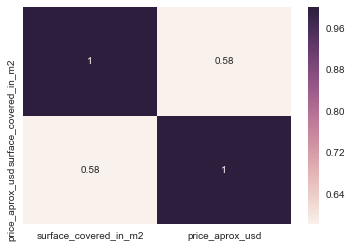

In [38]:
sns.heatmap(dataframe[[CAMPO_SUPERFICIE,'price_aprox_usd']].corr(), annot=True)

## Precio

Observamos outliers en los precios por lo que los eliminamos para que no formen parte del entrenamiento de nuestro modelo. ** Solo lo hago si el parametro ELIMINAR_OUTLIER_PRECIOS es True **

In [39]:
# Obtengo la media de las propiedades que tienen precio (price_aprox_usd no es NaN)
mean = dataframe.loc[~dataframe['price_aprox_usd'].isnull(), 'price_aprox_usd'].mean()

# Si la configuración lo especifíca, elimino los outliers de precio
if ELIMINAR_OUTLIER_PRECIOS:    
            
    # Si la media no es NaN
    if (~np.isnan(mean)):
        # Obtengo la desviacion estandar
        std_dev = dataframe.loc[~dataframe['price_aprox_usd'].isnull(), 'price_aprox_usd'].std()
            
        # Obtengo los outliers para el lugar y tipo de propiedad
        df_outliers = dataframe.loc[(np.abs(dataframe['price_aprox_usd'] - mean) > 3 * std_dev)] # Que esten por encima o debajo de 3 desviaciones std.
        
        # Los elimino del dataframe original
        dataframe = dataframe.drop(df_outliers.index)

** Observamos la correlación entre precio y superficie cubierta despues de corregir los outliers **

In [40]:
dataframe[[CAMPO_SUPERFICIE,'price_aprox_usd']].corr()

,surface_covered_in_m2,price_aprox_usd
surface_covered_in_m2,1.000,0.623
price_aprox_usd,0.623,1.000


## Columnas sin uso
Eliminamos el resto de columnas que no tienen uso para nuestro modelo ni análisis en el dataframe.

In [41]:
# Agregamos las columnas a eliminar
add_column_to_drop('operation',dataframe)
add_column_to_drop('geonames_id',dataframe)
add_column_to_drop('properati_url',dataframe)
add_column_to_drop('title',dataframe)
add_column_to_drop('image_thumbnail',dataframe)

# Las eliminamos defnitivamente
dataframe = dataframe.drop(cols_to_drop, axis=1)
cols_to_drop = []

La columna " operation " va a ser eliminada del DataFrame
La columna " geonames_id " va a ser eliminada del DataFrame
La columna " properati_url " va a ser eliminada del DataFrame
La columna " title " va a ser eliminada del DataFrame
La columna " image_thumbnail " va a ser eliminada del DataFrame


## Propiedades por zona
Decidimos solo utilizar las zonas que tienen mas de 50 propiedades publicadas.

In [42]:
# Obtenemos solo las zonas que tienen mas de 50 propiedades publicadas
# El uso de la columna property_type es indiferente. Solo necesito contar la cantidad de registros agrupados por lugar
#df_zonas_count = dataframe.groupby(by='place').agg({'property_type':'count'})

# Obtengo los nombres de las zonas
#zonas_mayores_50 = df_zonas_count.loc[df_zonas_count['property_type'] > 100].index

# Obtengo solo las zonas con mas de 50 propiedades
#dataframe = dataframe.loc[dataframe['place'].isin(zonas_mayores_50)]

## Feature Engineering
Generación de Features

### Antiguedad
Intentamos obtener la antiguedad de la descripción y se la asignamos al campu antig. <br>
Luego intentamos buscar si la propiedad es a estrenar y le asignamos 0 al campo antig<br>
Por último, creamos un flag para indicarle al modelo las propiedades de las cuales no pudimos obtener la antiguedad y luego le establecemos 0 a esas también.

In [43]:
# Obtengo los años de antiguedad mediante la descripcion
tmp = dataframe['description'].str.lower().str.extract("(\d+)(\s+|())(a(ñ|ã±|n)o)", expand=False)

dataframe['antig'] = tmp[0]

# Le asignamos 0 a las propiedades que son a estrenar y que no les hayamos estableciod una antiguedad
dataframe.loc[(dataframe['antig'].isnull()) & (dataframe['description'].str.lower().str.contains('estrenar')), 'antig'] = 0

# Creamos un flag para las propiedades de las cuales no tenemos su antiguedad
dataframe['antig_missing'] = 0

# Le asignamos el valor 1 a las propiedades cuyo valor de antig es NaN
dataframe.loc[dataframe['antig'].isnull(),'antig_missing'] = 1

# Le asignamos el valor 0 a las propiedades cuyo valor de antig es NaN
dataframe.loc[dataframe['antig'].isnull(),'antig'] = 0

# Por último convierto el tipo de dato a int
dataframe['antig'] = dataframe['antig'].astype(int)

### Eliminamos la columna description, lat y lon

In [44]:
add_column_to_drop('description',dataframe)
add_column_to_drop('lat', dataframe)
add_column_to_drop('lon', dataframe)
# Las eliminamos defnitivamente
dataframe = dataframe.drop(cols_to_drop, axis=1)
cols_to_drop = []

La columna " description " va a ser eliminada del DataFrame
La columna " lat " va a ser eliminada del DataFrame
La columna " lon " va a ser eliminada del DataFrame


## Estructura Final
Observamos la estructura y valores finales del modelo previo al entrenamiento

In [45]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99433 entries, 0 to 121219
Data columns (total 12 columns):
property_type            99433 non-null object
price_aprox_usd          85814 non-null float64
surface_total_in_m2      72990 non-null float64
surface_covered_in_m2    99433 non-null float64
floor                    99433 non-null float64
expenses                 99433 non-null int32
floor_was_nan            99433 non-null int32
place                    99433 non-null object
rooms_was_nan            99433 non-null int32
m2_per_room              99433 non-null float64
antig                    99433 non-null int32
antig_missing            99433 non-null int64
dtypes: float64(5), int32(4), int64(1), object(2)
memory usage: 8.3+ MB


In [46]:
# Obtengo la Info
df_info = inspect_dataframe(dataframe)
# Muestro la info
df_info

,NaNs #,NaNs %,Type
surface_total_in_m2,26443,26.594,float64
price_aprox_usd,13619,13.697,float64
property_type,0,0.000,object
surface_covered_in_m2,0,0.000,float64
floor,0,0.000,float64
expenses,0,0.000,int32
floor_was_nan,0,0.000,int32
place,0,0.000,object
rooms_was_nan,0,0.000,int32
m2_per_room,0,0.000,float64


## Correlación final
Observamos nuevamente la correlación de features luego del tratamiento de los datos.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text xticklabel objects>)

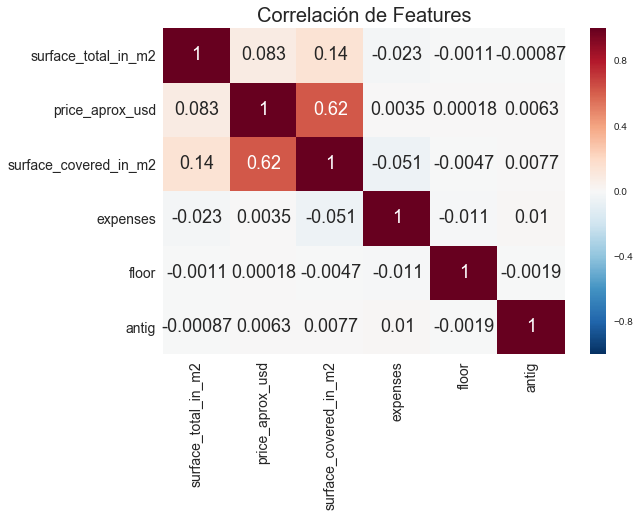

In [47]:
plt.figure(figsize=(9,6))
sns.heatmap(dataframe[['surface_total_in_m2','price_aprox_usd','surface_covered_in_m2','expenses', 'floor','antig']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Correlación de Features', fontsize=20)
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=14)

### Eliminamos la columna surface_covered_in_m2<br>
La columna **surface_covered_in_m2** no tiene tanta relación con el precio como sí la tiene surface_total_in_m2

In [48]:
dataframe = dataframe.drop('surface_total_in_m2', axis=1)

### Eliminación de columnas que no se utilizan
Eliminamos las columnas que no van a ser utilizadas en nuestro modelos de acuerdo a la configuración

In [49]:
# Columna Floor
if UTILIZAR_FLOOR == False:
    dataframe = dataframe.drop(['floor','floor_was_nan'], axis=1)
    
# Columna Expenses
if UTILIZAR_EXPENSES == False:
    dataframe = dataframe.drop(['expenses'], axis=1)
    
# Columna Rooms
if UTILIZAR_ROOMS == False:
    dataframe = dataframe.drop(['rooms','rooms_was_nan'], axis=1)

# Columna antiguedad
if UTILIZAR_ANTIGUEDAD == False:
    dataframe.drop(['antig_missing','antig'], axis=1, inplace=True)

# Eliminar datos duplicados
if ELIMINAR_DUPLICADOS:
    dataframe = dataframe.drop_duplicates()

In [50]:
dataframe

,property_type,price_aprox_usd,surface_covered_in_m2,floor,expenses,floor_was_nan,place,rooms_was_nan,m2_per_room,antig,antig_missing
0,PH,62000.000,40.000,1.000,0,1,Argentina|Capital Federal|Mataderos|,0,20.000,0,1
2,apartment,72000.000,55.000,1.000,0,1,Argentina|Capital Federal|Mataderos|,0,27.500,0,1
4,apartment,64000.000,35.000,1.000,0,1,Argentina|Buenos Aires Costa Atlántica|Mar del...,-1,14.530,0,1
6,PH,130000.000,78.000,1.000,0,1,Argentina|Bs.As. G.B.A. Zona Norte|Vicente Lóp...,-1,23.739,0,1
7,apartment,138000.000,40.000,1.000,0,1,Argentina|Capital Federal|Belgrano|,0,40.000,0,0
8,apartment,195000.000,60.000,1.000,0,1,Argentina|Capital Federal|Belgrano|,-1,21.894,0,0
12,apartment,115000.000,36.000,1.000,0,1,Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|...,0,18.000,0,1
13,apartment,111700.000,30.000,1.000,0,1,Argentina|Capital Federal|Palermo|Palermo Soho,0,30.000,0,1
14,apartment,147900.000,31.000,1.000,0,1,Argentina|Capital Federal|Palermo|Palermo Soho,0,31.000,0,1
16,PH,239000.000,98.000,1.000,0,1,Argentina|Capital Federal|Mataderos|,0,24.500,0,1


# Generación del Modelo

## Definición de columnas a utilizar
###  Fit
Elegimos las columnas que son significativas para la predicción:<br>
* floor
* expenses
* rooms
* surface_covered_in_m2
* property_type
* place_with_parent_names

### Columna label
Esta columna la vamos a utilizar para indicar el valor de cada registro
* price_aprox_usd


## Ciudades a predecir
Debido a que vamos a predecir valores de una colección específica de datos, solo nos interesa entrenar el modelo con las ciudades que estan dentro de los valores a predecir. El resto los eliminamos del dataset para tener una menor varianza.

In [51]:
# Cuento la cantidad de propiedades por ciudad. 
# Utilizo cualquier columna ya que me interesa el valor de filas y no el de alguna columna en particular
df_propiedades_por_place = dataframe[['place','property_type']].groupby(by='place').count()

# Cambio el nombre de la columna para no confundir datos
df_propiedades_por_place = df_propiedades_por_place.rename(index=str,columns={'property_type':'cant_props'})


# Obtengo los lugares que tienen una cantidad de propiedades mayor a la cantidad de columnas
places_for_model = df_propiedades_por_place.loc[df_propiedades_por_place['cant_props'] > len(dataframe.columns)]

# Dejamos solo las ciudades que tienen mas propiedades que características
model_dataframe = dataframe.loc[dataframe['place'].isin(places_for_model.index)]

In [52]:
# Cuento la cantidad de propiedades por ciudad. 
# Utilizo cualquier columna ya que me interesa el valor de filas y no el de alguna columna en particular
df_propiedadespor_tipo = dataframe.groupby(by=['property_type','place']).count()

## Normalizacion

### Normalizo los label con log1p

In [53]:
from sklearn.preprocessing import FunctionTransformer

# Instancio el Optimus Prime con log1p
transformer = FunctionTransformer(np.log1p)

# Obtengo los valores de precio que no son NaN, como un numpy array
price = model_dataframe.loc[~model_dataframe['price_aprox_usd'].isnull(),'price_aprox_usd'].copy().values

# Aplico la transformación y la asigno directamente a la columna de precio
model_dataframe.loc[~model_dataframe['price_aprox_usd'].isnull(),'price_aprox_usd'] = transformer.transform([price])[0]

C:\Users\Juanu\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Normalizamos los X con MinMax

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

minmaxscaler_model = MinMaxScaler()

# Columnas a normalizar
columnas= [CAMPO_SUPERFICIE]

# Si calcula distancia con barrio privado
if IDENTIFICAR_BARRIOS_PRIVADOS:
    columnas.append('distancia_barrio_privado')

# Si calcula superficie por ambiente y uso ROOMS
if CALCULAR_SUPERFICIE_POR_AMBIENTE & UTILIZAR_ROOMS:
    # También normalizar rooms por m2
    columnas.append('m2_per_room')
elif UTILIZAR_ROOMS & (~CALCULAR_SUPERFICIE_POR_AMBIENTE):
    columnas.append('rooms')

# Si utilizamos antiguedad
if UTILIZAR_ANTIGUEDAD:
    columnas.append('antig')
    
# Si utilizamos floor
if UTILIZAR_FLOOR:
    columnas.append('floor')
    
# Si utilizamos expensas
if UTILIZAR_EXPENSES:
    columnas.append('expenses')
    

# Aplico scale a las columnas elegidas
model_dataframe[columnas] = minmaxscaler_model.fit_transform(model_dataframe[columnas])

C:\Users\Juanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Juanu\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Columnas Dummies
Convertimos las columnas categórias a columnas Dummy.

### Property Type
Obtenemos las dummies de property type

In [55]:
# Obtenemos las columnas dummies de property_type
df_property_type = pd.get_dummies(model_dataframe['property_type'], drop_first=True, prefix='property_type_')

# Agregamos las columnas dummies concatenando el dataframe original con las dummies
dataframe_with_dummies = pd.concat([model_dataframe, df_property_type], axis=1)

# Eliminamos la columna property_type del dataframe nuevo
dataframe_with_dummies = dataframe_with_dummies.drop('property_type', axis=1)

### Place
Obtenemos las dummies de place si es que se usa . Sino eliminamos la feature place.

In [56]:
if UTILIZAR_UBICACION:
    # Obtenemos las columnas dummies de place_with_parent_names
    df_places = pd.get_dummies(model_dataframe['place'], drop_first=True, prefix='place_')
    
    # Agreamos las columnas dummies concatenando el nuevo dataframe con las dummies
    dataframe_with_dummies = pd.concat([dataframe_with_dummies, df_places], axis=1)
    
    # Eliminamos la columna place_with_parent_names del nuevo dataframe
    dataframe_with_dummies = dataframe_with_dummies.drop('place', axis=1)
    
    # Guardamos el nombre de cada PLACE en la variable places
    places = df_places.columns
else:
    dataframe_with_dummies = dataframe_with_dummies.drop('place', axis=1)

### Barrio Privado
Obtenemos las dummies de Barrio Privado si se usa.

In [57]:
if IDENTIFICAR_BARRIOS_PRIVADOS:
    # Obtenemos las columnas dummies de nombre_barrio_privado
    df_barrios = pd.get_dummies(model_dataframe['nombre_barrio_privado'], drop_first=True, prefix='nombre_barrio_')
    
    # Agreamos las columnas dummies concatenando el nuevo dataframe con las dummies
    dataframe_with_dummies = pd.concat([dataframe_with_dummies, df_barrios], axis=1)
    
    # Eliminamos la columna nombre_barrio_privado del nuevo dataframe
    dataframe_with_dummies = dataframe_with_dummies.drop('nombre_barrio_privado', axis=1)
    
    # Guardamos el nombre de cada BARRIO en la variable BARRIOS
    barrios = df_places.columns

## Place x Superficie
Creamos otra colección de features mutiplicando la superficie de la propiedad * el lugar. Esto va a generar un $\beta$ distinto para cada propiedad, dependiendo del lugar donde está.

In [58]:
if PLACE_X_SURFACE:
    # Obtengo el array de numpy de Superficies
    arr_superficie = model_dataframe[CAMPO_SUPERFICIE].values

    # La paso de 1 dimension a 2.
    arr_superficie = arr_superficie[:, None]
    
    # Calculo el producto de cada columna de lugar x la superficie para obtener una columna de superficie para cada lugar.
    df_mul_places = pd.DataFrame(df_places.values * arr_superficie)
    
    #df_mul_places.reset_index(drop=True, inplace=True)
    dataframe_with_dummies.reset_index(drop=True, inplace=True)
    
    # Le agrego las nuevas columnas al datafra,e
    dataframe_with_dummies = pd.concat( [dataframe_with_dummies, df_mul_places], axis=1) 

## Property Type x Superficie
Creamos otra colección de features mutiplicando la superficie de la propiedad * el tipo de propiedad. Esto va a generar un $\beta$ distinto para cada propiedad, dependiendo del tipo de propiedad.

In [59]:
if PROPERTY_TYPE_X_SURFACE:
    # Obtengo el array de numpy de Superficies
    arr_superficie = model_dataframe[CAMPO_SUPERFICIE].values 
    
    # La paso de 1 dimension a 2.
    arr_superficie = arr_superficie[:, None]
        
    # Calculo el producto de cada columna de lugar x la superficie para obtener una columna de superficie para cada lugar.
    df_mul_property_type = pd.DataFrame(df_property_type.values * arr_superficie)
    
    #df_mul_property_type.reset_index(drop=True, inplace=True)
    dataframe_with_dummies.reset_index(drop=True, inplace=True)
    
    # Le agrego las nuevas columnas al datafra,e
    dataframe_with_dummies = pd.concat( [dataframe_with_dummies, df_mul_property_type], axis=1) 

## Expenses x Place

In [60]:
if UTILIZAR_EXPENSES:
    # Obtengo el array de numpy de Expenses
    arr_expenses = model_dataframe['expenses'].values

    # La paso de 1 dimension a 2.
    arr_expenses = arr_expenses[:, None]
    
    # Calculo el producto de cada columna de lugar x la superficie para obtener una columna de superficie para cada lugar.
    df_mul_expenses = pd.DataFrame(df_places.values * arr_expenses)
    
    #df_mul_places.reset_index(drop=True, inplace=True)
    dataframe_with_dummies.reset_index(drop=True, inplace=True)
    
    # Le agrego las nuevas columnas al datafra,e
    dataframe_with_dummies = pd.concat( [dataframe_with_dummies, df_mul_expenses], axis=1) 
    
    # Elimino la columna Expenses
    dataframe_with_dummies = dataframe_with_dummies.drop('expenses', axis=1)

## Barrio Privado x Distancia con Barrio privado

In [61]:
if IDENTIFICAR_BARRIOS_PRIVADOS:
    # Obtengo el array de numpy de distancias con barrio privado
    arr_distancia = model_dataframe['distancia_barrio_privado'].values

    # La paso de 1 dimension a 2.
    arr_distancia = arr_distancia[:, None]
    
    # Calculo el producto de cada columna de barrio x la dstancia para obtener una columna de distanca para cada barrio.
    df_mul_barrio = pd.DataFrame(df_barrios.values * arr_distancia)
    
    #df_mul_places.reset_index(drop=True, inplace=True)
    dataframe_with_dummies.reset_index(drop=True, inplace=True)
    
    # Le agrego las nuevas columnas al datafra,e
    dataframe_with_dummies = pd.concat( [dataframe_with_dummies, df_mul_barrio], axis=1) 
    
    # Elimino la columna distancia_barrio_privado
    dataframe_with_dummies = dataframe_with_dummies.drop('distancia_barrio_privado', axis=1)

## Preparación de Features y Labels de Entrenamiento y Test
Utilizamos el modelo de Regresión Lineal y lo entrenamos con nuestros datos de entrenamiento

### Separo los datos que tienen precio de los que no

In [62]:
def get_train_predict_sets(df):
    # Guardo las filas que tienen el precio en NaN en la variable data_frame_empty_price
    dataframe_predict = df.loc[df['price_aprox_usd'].isnull()]

    # Luego, elimino esas filas del dataframe original.
    dataframe_train = df.drop(dataframe_predict.index)

    return dataframe_train, dataframe_predict

### Valores y Labels
Del dataframe, separamos nuestros labels de los valores a utilizar para entrenar

In [63]:
def get_features_labels(df):
    "Separa las features de los labels de un dataframe y los devuelve en el orden FEATURES, LABELS (X, Y)"
    
    # Obtengo los labels (precio aprox en USD)
    Y = df['price_aprox_usd']

    # Obtengo los valores sin los labels
    X = df.drop('price_aprox_usd', axis=1)
    
    return X, Y

### Holdout Sets
De nuestros datos de entrenamiento con labels conocidos, separamos un porcentaje con el cual entrenaremos el modelo, y otro porcentaje con el cual haremos la validación. Vamos a usar un 70% para el entrenamiento y un 30% para la validación.

In [64]:
# Utilizamos el método train_test_split de Scikit Learn para separar los datos
from sklearn.model_selection import train_test_split

def get_houldout_sets(X,Y, random_state, train_size):   
    
    # obtenemos X e Y de test y entrenamiento.
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, train_size=train_size)
    
    return X_train, X_test, Y_train, Y_test

## Entrenamiento y predicción de los valores test para TODAS las Zonas
Entrenamos el modelo con todos los valores y verificamos el score

### Cross Validation de Modelos

In [65]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.sparse import csr_matrix

# Dataframe donde muestro los resultados
df_resultados = pd.DataFrame(columns=['Model', 'MSE', 'R^2', 'Alpha'])

# Obtengo los dataframe de train y predict
df_train, df_predict = get_train_predict_sets(dataframe_with_dummies)

# Obtengo los features y labels por separado
X, Y = get_features_labels(df_train)

#X = PolynomialFeatures().fit_transform(X)


# Obtengo los sets de entrenamiento y de test con un 70% de valores de entrenamiento (30% de test)
X_train, X_test, Y_train, Y_test = get_houldout_sets(X, Y, random_state=1, train_size=0.70)

### Cantidad de registros

In [66]:
print('Se entrenarán a los modelos con ',len(X_train),'registros')

Se entrenarán a los modelos con  52803 registros


### Regresion lineal

In [67]:
# Importamos librerias de scikit learn
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Instancio el modelo
lin_model = linear_model.LinearRegression()
# Fiteo el modelo
lin_model.fit(X_train, Y_train)
# Predigo los valores 
Y_predicted_linear = lin_model.predict(X_test)
# Ejecuto una cross validation de 5 folds
mse_score_linear = cross_val_score(lin_model, X, Y, cv=5, scoring='neg_mean_squared_error') * -1
r2_score_linear = cross_val_score(lin_model, X, Y, cv=5)


# Agrego los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'MSE': mse_score_linear.mean(), 'R^2': r2_score_linear.mean(), 'Alpha': 0, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,0.339,0.390,0,1249.000


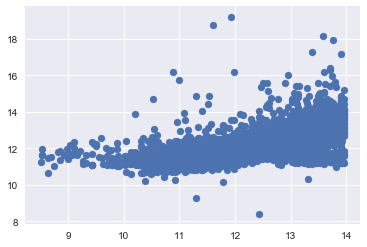

In [68]:
plt.scatter(x=Y_test, y =Y_predicted_linear)

### Ridge

In [69]:
# Instancio el modelo
ridge_model = linear_model.RidgeCV(cv=5)
# Fiteo el modelo
ridge_model_fitted = ridge_model.fit(X_train, Y_train)
# Predigo los valores 
Y_predicted_ridge = ridge_model_fitted.predict(X_test)
# Obtengo el score R2
r2_score_ridge = ridge_model_fitted.score(X, Y)
# Obtengo el MSE
mse_score_ridge = mean_squared_error(Y_test, Y_predicted_ridge)


# Agrego los resultados al dataframe de resultados
row = {'Model':'Ridge', 'MSE': mse_score_ridge.mean(), 'R^2': r2_score_ridge.mean(), 'Alpha': ridge_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,0.339,0.390,0,1249.000
1,Ridge,0.201,0.639,0.100,1249.000


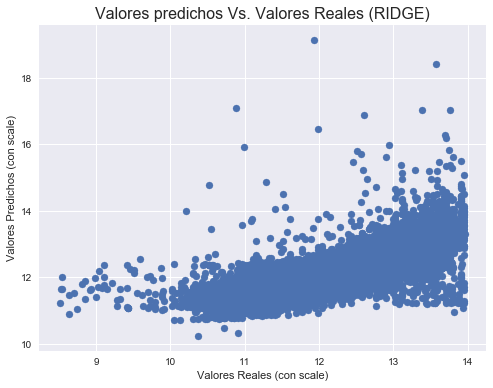

In [70]:
plt.figure(figsize=(8,6))
plt.scatter(x=Y_test, y =Y_predicted_ridge)
plt.title('Valores predichos Vs. Valores Reales (RIDGE)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

### Lasso

In [71]:
# Instancio el modelo
lasso_model = linear_model.LassoCV(cv=5,max_iter=2000)
#Fiteo el modelo
lasso_model_fitted = lasso_model.fit(X_train,Y_train)
# Predigo los datos
Y_predicted_lasso = lasso_model_fitted.predict(X_test)
# Obtengo el score R2
r2_score_lasso = lasso_model_fitted.score(X, Y)
# Obtengo el MSE
mse_score_lasso = mean_squared_error(Y_test, Y_predicted_lasso)

# Agrego los resultados al dataframe de resultados
row = {'Model':'Lasso', 'MSE': mse_score_lasso.mean(), 'R^2':r2_score_lasso.mean(), 'Alpha': lasso_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,0.339,0.390,0,1249.000
1,Ridge,0.201,0.639,0.100,1249.000
2,Lasso,0.214,0.607,0.000,1249.000


## Elimino las columnas cuyos coeficientes son cero y pruebo nuevamente
Eliminamos las columnas cuyos coeficientes son cero y luego ejecutamos Lasso nuevamente

In [72]:
# Elimino las columnas de X cuyos coeficientes son 0 (cero)
X = X[X.columns[np.nonzero(lasso_model_fitted.coef_)]]

# Obtengo el test split
X_train, X_test, Y_train, Y_test = get_houldout_sets(X, Y, random_state=1, train_size=0.70)

### Ridge

In [73]:
# NO EJECUTO ESTO
if True == False:
    
    # Instancio el modelo
    ridge_model = linear_model.RidgeCV(cv=5)
    # Fiteo el modelo
    ridge_model_fitted = ridge_model.fit(X_train, Y_train)
    # Predigo los valores 
    Y_predicted_ridge = ridge_model_fitted.predict(X_test)
    # Obtengo el score R2
    r2_score_ridge = ridge_model_fitted.score(X, Y)
    # Obtengo el MSE
    mse_score_ridge = mean_squared_error(Y_test, Y_predicted_ridge)
    
    
    # Agrego los resultados al dataframe de resultados
    row = {'Model':'Ridge sin coef 0', 'MSE': mse_score_ridge.mean(), 'R^2': r2_score_ridge.mean(), 'Alpha': ridge_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
    df_resultados = df_resultados.append(row, ignore_index=True)
    
    # Muestro los resultados
    df_resultados

### Lasso

In [74]:
# Instancio el modelo
lasso_model = linear_model.LassoCV(cv=5,max_iter=2000)
#Fiteo el modelo
lasso_model_fitted = lasso_model.fit(X_train,Y_train)
# Predigo los datos
Y_predicted_lasso = lasso_model_fitted.predict(X_test)
# Obtengo el score R2
r2_score_lasso = lasso_model_fitted.score(X, Y)
# Obtengo el MSE
mse_score_lasso = mean_squared_error(Y_test, Y_predicted_lasso)

# Agrego los resultados al dataframe de resultados
row = {'Model':'Lasso sin coef 0', 'MSE': mse_score_lasso.mean(), 'R^2':r2_score_lasso.mean(), 'Alpha': lasso_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados


,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,0.339,0.390,0,1249.000
1,Ridge,0.201,0.639,0.100,1249.000
2,Lasso,0.214,0.607,0.000,1249.000
3,Lasso sin coef 0,0.214,0.607,0.000,301.000


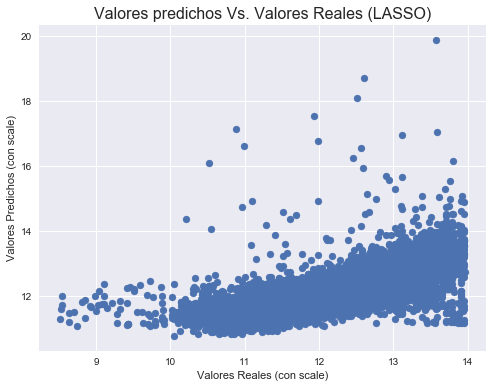

In [75]:
plt.figure(figsize=(8,6))
plt.scatter(x=Y_test, y =Y_predicted_lasso)
plt.title('Valores predichos Vs. Valores Reales (LASSO)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

## Mejores Resultados


|Model            |MSE  |R^2    |Alpha | Columnas |
|-----------------|-----|-------|------|-----------
|Linear Regression|0.339|0.390  |NaN   |1249      |
|Ridge            |0.201|0.639  |0.100 |1249      |
|Lasso            |0.214|0.607  |0.000 |1249      |
|Lasso sin coef 0 |0.214|0.607  |0.000 |301       |

### DataFrame con los resultados
Armamos un dataframe que contenga los resultados predichos en cada modelo

In [76]:
#  Me guardo los indices originales para poder identificar luego cada fila
y_index = Y_test.index
# Reinicio los indices para poder unir los Y de tes ty los Y predichos
Y_test_indexless = Y_test.reset_index(drop=True)

# Concateno los Y de todos los modelos
Y_values = pd.DataFrame({'y_real': Y_test_indexless, 'y_linear': Y_predicted_linear ,'y_ridge': Y_predicted_ridge, 'y_lasso': Y_predicted_lasso})

#pd.Series(Y_predicted_ridge).describe()
# Le asigno el nombre a las columnas
#Y_values.columns = ['Y Real','Y Predicted Linear','Y Predicted Ridge', 'Y Predicted Lasso',]

### Outliers en las predicciones
Encontramos que hay algunos outliers en las predicciones.<br>
Vamos a observar los resultados eliminandolos. Para esto debemos realizar varios pasos para asignar los valores predichos al dataframe original.

In [77]:
# Elimino los outliers de los valores predichos de cada modelo
df_result_sin_outliers_lasso = Y_values[np.abs(Y_values['y_lasso']-Y_values['y_lasso'].mean())<=(3*Y_values['y_lasso'].std())].copy()
df_result_sin_outliers_ridge = Y_values[np.abs(Y_values['y_ridge']-Y_values['y_ridge'].mean())<=(3*Y_values['y_ridge'].std())].copy()
df_result_sin_outliers_linear = Y_values[np.abs(Y_values['y_linear']-Y_values['y_linear'].mean())<=(3*Y_values['y_linear'].std())].copy()

# Por ultimo agrego una nueva columna con la diferencia entre lo predicho y lo real
df_result_sin_outliers_lasso['result_dif'] = df_result_sin_outliers_lasso['y_real']-df_result_sin_outliers_lasso['y_lasso']
df_result_sin_outliers_ridge['result_dif'] = df_result_sin_outliers_ridge['y_real']-df_result_sin_outliers_ridge['y_ridge']
df_result_sin_outliers_linear['result_dif'] = df_result_sin_outliers_linear['y_real']-df_result_sin_outliers_linear['y_linear']

### Ploteamos los resultados sin los outliers de las predicciones

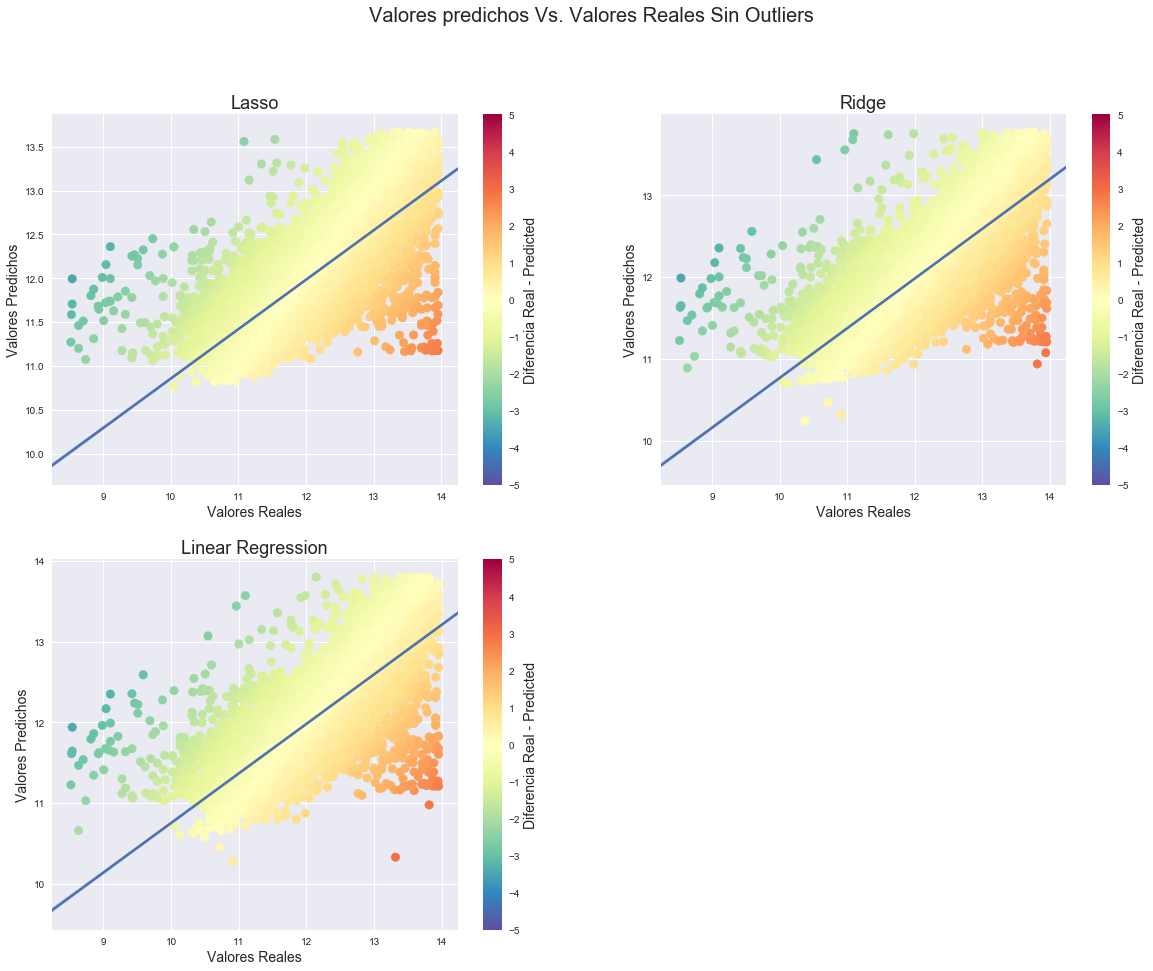

In [78]:
# Ploteo los valores de Y sin outliers
plt.figure(figsize=(20,15))

# Defino los ticks con los valores de las colorbar
colorbar_ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

# LASSO
plt.subplot(2,2,1)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_lasso['y_real'], y=df_result_sin_outliers_lasso['y_lasso'],c=df_result_sin_outliers_lasso['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
ax1 = sns.regplot(x="y_real", y="y_lasso", data=df_result_sin_outliers_lasso, scatter=False,)
# Establezco los títulos
plt.title('Lasso', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# RIDGE
plt.subplot(2,2,2)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_ridge['y_real'], y=df_result_sin_outliers_ridge['y_ridge'],c=df_result_sin_outliers_ridge['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_ridge", data=df_result_sin_outliers_ridge, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales', fontsize=20)
plt.title('Ridge', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# LINEAR
plt.subplot(2,2,3)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_linear['y_real'], y=df_result_sin_outliers_linear['y_linear'],c=df_result_sin_outliers_linear['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_linear", data=df_result_sin_outliers_linear, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales Sin Outliers', fontsize=20)
plt.title('Linear Regression', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)


In [79]:
df_result_sin_outliers_ridge.describe()

,y_lasso,y_linear,y_real,y_ridge,result_dif
count,22420.000,22420.000,22420.000,22420.000,22420.000
mean,11.978,11.976,11.989,11.976,0.013
std,0.509,0.552,0.724,0.543,0.426
min,10.772,8.425,8.517,10.239,-3.451
25%,11.587,11.564,11.458,11.567,-0.219
50%,11.924,11.895,11.918,11.902,0.002
75%,12.280,12.311,12.487,12.307,0.235
max,14.908,18.763,13.964,13.774,2.877
